# Image segmentation using U-Net
References:
- [Guide](https://medium.com/@alessandromondin/semantic-segmentation-with-pytorch-u-net-from-scratch-502d6565910a)
- [Handling COCO dataset](https://www.kaggle.com/code/armanasgharpoor1993/coco-dataset-tutorial-image-segmentation)
- [Generating class-wise masks](https://github.com/Tramac/awesome-semantic-segmentation-pytorch/blob/master/core/data/dataloader/mscoco.py)

In [6]:
# Import necessary libraries
import numpy as np
import os, sys 
from importlib import reload
import matplotlib.pyplot as plt
import fiftyone as fo 
import fiftyone.zoo as foz
import fiftyone.utils.labels as foul
from collections import defaultdict
import custom_dataloader
reload(custom_dataloader)
from custom_dataloader import COCODataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms as T
import torch.nn.functional as F

In [7]:
# Load dataset

# Save to current directory
curr_dir = os.getcwd()
fo.config.dataset_zoo_dir = curr_dir 

# Download the data 
dataset = foz.load_zoo_dataset("coco-2017",
                            splits=['train'],
                            shuffle=True,
                            seed=0,
                            max_samples=100,
                            label_type=['segmentations'],
                            only_matching=True,
                            classes=['person', 'cat', 'car'])

Found annotations at '/Users/sudhansh/Desktop/Projects/Machine Learning Practice/Segmentation U-Net/coco-2017/raw/instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Ignoring unsupported parameter 'label_type' for importer type <class 'fiftyone.utils.coco.COCODetectionDatasetImporter'>
Loading existing dataset 'coco-2017-train-100'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [8]:
detections_field = "detections"
segmentations_field = "segmentations"

foul.objects_to_segmentations(
    dataset,
    detections_field,
    segmentations_field,
)

ValueError: Dataset has no sample field 'detections'

In [2]:
# Dataset loader for PyTorch

dataDir='./coco-2017/'
dataType='train2017'
# annFile='{}raw/instances_{}.json'.format(dataDir, dataType)
annFile='{}labels.json'.format(dataDir)

imageDir = '{}train/data/'.format(dataDir)
filter_classes = ['person', 'cat', 'car']
size = 256
max_num = None

# Initialize the COCO api for instance annotations
coco_dataset = COCODataset(imageDir, annFile, filter_classes, size, max_num)


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loaded 2000 images


In [ ]:
def dice_loss()

In [4]:
# Load the model
import classes_succinct
reload(classes_succinct)
from classes_succinct import UNet 

# Parameters
batch_size = 16
learning_rate = 5e-3
num_epochs = 5
n_down = 4
input_channels = 3
first_out_channels = 8 
output_classes = 4
device = torch.device('mps')

data_loader = DataLoader(coco_dataset, batch_size=batch_size, shuffle=True)

# 4 classes output - person, cat, car, background
model = UNet(input_channels, first_out_channels, output_classes, n_down)
    
# Define loss function
# criterion = nn.CrossEntropyLoss()  # You can change to Dice Loss or other appropriate loss
criterion = torch.hub.load(
	'adeelh/pytorch-multi-class-focal-loss',
	model='focal_loss',
	alpha=torch.tensor([0.3, 0.3, 0.3, 0.1]),
	gamma=0,
    device=device,
	reduction='mean',
	force_reload=False
)
 
# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set device
model.to(device)


Using cache found in /Users/sudhansh/.cache/torch/hub/adeelh_pytorch-multi-class-focal-loss_master


UNet(
  (model): UNetBlock(
    (model): Sequential(
      (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): UNetBlock(
        (model): Sequential(
          (0): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): UNetBlock(
            (model): Sequential(
              (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
              (3): UNetBlock(
                (model): Sequential(
                  (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
                  (1): BatchNorm2d(64, eps=1e-05, momen

In [14]:
print(len(coco_dataset))

2000


In [5]:
# Training
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in data_loader:
        images, masks = images.to(device), masks.to(device)
        print(images.shape)
        # Forward pass
        outputs = model(images)
        
        # Calculate loss
        flattened_output = outputs.reshape([batch_size, output_classes, -1])
        flattened_masks = masks.reshape([batch_size, -1]).long()
        loss = criterion(flattened_output, flattened_masks)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)

    
    epoch_loss = running_loss / len(coco_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

dict_keys(['id', 'image_id', 'category_id', 'bbox', 'area', 'iscrowd', 'supercategory'])


KeyError: 'segmentation'

In [ ]:
print(images.shape)
image = images[0, ...].permute([1, 2, 0]).cpu()
print(masks.shape)
mask = masks[0, ...].reshape(size, size).cpu()
print(outputs[0, ...].shape)
output = torch.argmax(outputs[0, ...], dim = 0)
gimage = image[:, :, 0] * 0.2989 + image[:, :, 1] * 0.5870 + image[:, :, 2] * 0.1140
output = output.reshape(size, size).cpu()
print(gimage.shape, mask.shape, output.shape)

torch.Size([16, 3, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([4, 256, 256])
torch.Size([256, 256]) torch.Size([256, 256]) torch.Size([256, 256])


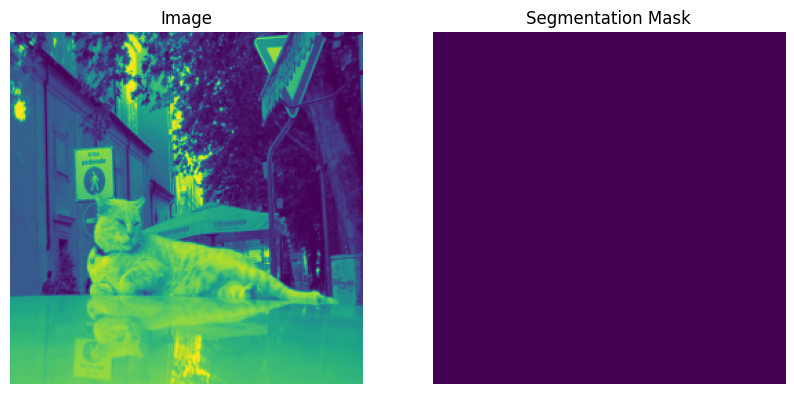

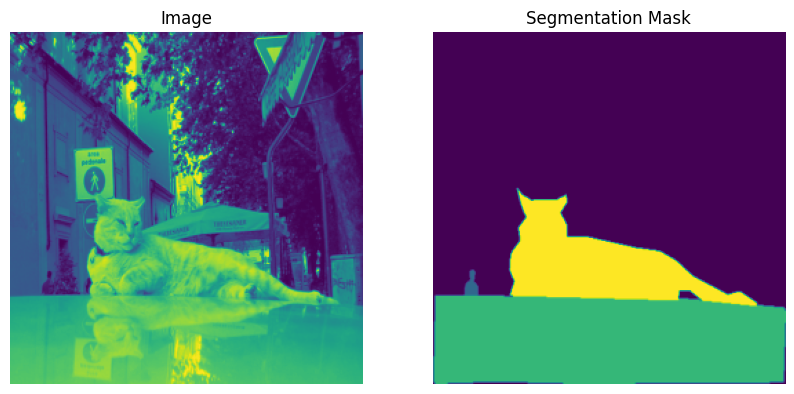

In [ ]:
def visualize_segmentation(image, mask, classes=None):
    """
    Visualizes an image and its corresponding segmentation mask.
    
    Parameters:
        image (numpy.ndarray): Input image.
        mask (numpy.ndarray): Segmentation mask.
        classes (list): List of class labels. If provided, the mask will be color-coded accordingly.
    """
    plt.figure(figsize=(10, 5))

    # Plot the image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')

    # Plot the segmentation mask
    plt.subplot(1, 2, 2)
    if classes:
        colored_mask = np.zeros_like(mask, dtype=np.uint8)
        for i, label in enumerate(classes):
            colored_mask[mask == i] = label
        plt.imshow(colored_mask)
        plt.title('Segmentation Mask (Color-coded)')
    else:
        plt.imshow(mask)
        plt.title('Segmentation Mask')
    plt.axis('off')

    plt.show()

# Visualize the image and mask
visualize_segmentation(gimage, output)
visualize_segmentation(gimage, mask)